In [152]:
import math

In [153]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [154]:
from graphviz import Digraph

In [155]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any  value in graph create a rantangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is result of some operation then create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot

In [156]:
import random

In [157]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), start=self.b)
        out = act.tanh()
        return out


x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9834455957141615)

In [158]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

x = [2.0, 3.0]
n = Layer(2, 4)
n(x)

[Value(data=-0.37486361122902473),
 Value(data=0.9975651496770966),
 Value(data=-0.9158265351021322),
 Value(data=0.46731711503523227)]

In [159]:
class MLP:
    def __init__(self, nin: int, nouts: list):
        """Initializes the Multilayer Perceptron

        Args:
            nin (int): The number of inputs
            nouts (list): The size of each layer
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0, 3.0]
n = MLP(2, [3, 4, 4, 1])
n(x)

[Value(data=-0.7015086109119727)]

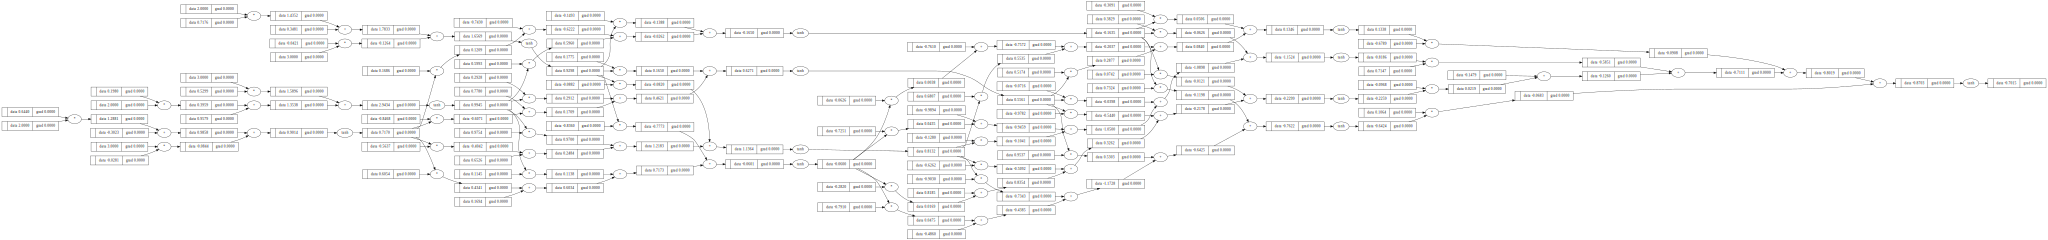

In [160]:
draw_dot(n(x)[0])

In [161]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), start=self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters
        #     params.extend(ps)
        
        # return params
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [162]:
x = [2.0, 3.0, 1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6546135017194629)

### Loss function

In [163]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [164]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.46592469990304053),
 Value(data=0.4676698316643702),
 Value(data=-0.09539371427049351),
 Value(data=-0.005900401420634019)]

In [165]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=6.133138110323066)

In [166]:
loss.backward()

In [167]:
n.layers[0].neurons[0].w[0].grad

1.2970853512661653

In [168]:
n.layers[0].neurons[0].w[0].data

0.9402007425699377

In [169]:
len(n.parameters())

41

### Gradient Descent

In [170]:
x = [2.0, 3.0, 1.0]
n = MLP(3, [4, 4, 1])
n(x)

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [171]:
# the loss has decreased
ypred = [n(x) for x in xs]
new_loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss, new_loss

(Value(data=6.133138110323066), Value(data=7.068871240024423))

In [172]:
n.layers[0].neurons[0].w[0].data, n.layers[0].neurons[0].w[0].grad

(-0.7878024114054925, 0.0)

In [173]:
for p in n.parameters():
    p.grad = 0.0
new_loss.backward()

In [174]:
for p in n.parameters():
    p.data += -0.1 * p.grad